In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from tools import *

# Dataset

The data used to train the model consist on steam reviews from the most relevant games on 20/2024 which can be found <a href='https://store.steampowered.com/games/?l=latam&flavor=contenthub_topsellers'> here</a>.

The first step is to get the game ids from the source, i was able to retrieve 224 reviews. Then the reviews of each game are obtained using the <a href='https://partner.steamgames.com/doc/store/getreviews'>Steam Api</a>

To get the reviews the following piece of code was used, then these are saved in the file reviews.csv . The amount of reviews are 59805. There are a lot of filters that can be applied on the reviews like:

- weighted_vote_score : Measure how useful is the review
- comment_count : The amount of comments asociated with the reviews
- votes_up : How many upvotes the review had
- votes_funny : The amount of votes of people that find that think the review is funny
 

In [3]:
# id_list = steam_ids_scrapper() #Obtenemos la lista de ids
# print(len(id_list))
# ids = id_list[:1000] #Busco los 500 primeros juegos mas relevantes

# # 'game_id', 'game_name', 'review', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score'
# reviews_data = {
#     'game_id':[], 
#     'game_name':[], 
#     'review':[], 
#     'voted_up':[], 
#     'votes_up':[],
#     'votes_funny':[],
#     'weighted_vote_score':[]
#     }

# for id in ids:
#     try:
#         revs_dict = id_reviews_scrapper(id=id,n_rev_per_game=400)
#     except requests.exceptions.HTTPError:
#         print(f'Problem with id {id} on id_reviews_scrapper')
#     else:
#         try:
#             rev_build = review_builder(revs_dict)
#         except requests.exceptions.HTTPError:
#             print(f'Problem with id {id} on review_builder')
#         else:
#             for key in list(reviews_data.keys()):
#                 reviews_data[key] = reviews_data[key] + rev_build[key]

In [5]:
path_1 = './reviews.csv'
path_2 = './reviews2.csv'
df_1 = pd.read_csv(path_1)
df_2 = pd.read_csv(path_2)
df1 = df_1.drop_duplicates(subset='review').reset_index(drop=True)
df2 = df_2.drop_duplicates(subset='review').reset_index(drop=True)
print(df2.drop_duplicates(subset='game_id').shape)
df = pd.concat([df2.reset_index(drop=True), df1.reset_index(drop=True)]).reset_index(drop=True)
df



(105, 7)


,game_id,game_name,review,voted_up,votes_up,votes_funny,weighted_vote_score
0,200710,Torchlight II,Yes I would recommend this game to others. So ...,True,68,7,0.872375
1,200710,Torchlight II,Play this instead of Diablo IV. No microtran...,True,173,12,0.866532
2,200710,Torchlight II,i regret my diablo 4 purchase,True,65,8,0.828379
3,200710,Torchlight II,gonn grab me some torchlight while waiting for...,True,27,1,0.772369
4,200710,Torchlight II,Great game.,True,36,6,0.768902
...,...,...,...,...,...,...,...
87702,1262240,NaN,ASI ASI,True,1,0,0.500000
87703,1262240,NaN,we want elements bruh,False,1,0,0.500000
87704,1262240,NaN,I'm not vegan,True,1,0,0.500000
87705,1262240,NaN,Space Cadet is the peak of multiplayer shooter...,True,1,0,0.500000


I found that using weighted_vote_score will drastically reduce the amount of reviews due that the mean si close to 0.58, also 75% are below of 0.6. A lot of reviews provide useful information, but seems not to be seen by many people, they have a weighted_vote_score of 0.5 instead other reviews that dont provide useful information and that are asociated with joke reviews get the most comments. 

In [6]:
df[df['votes_funny']==6274]

,game_id,game_name,review,voted_up,votes_up,votes_funny,weighted_vote_score
42628,1774580,STAR WARS Jedi: Survivor™,Runs like my ass after taco bell,False,5516,6274,0.91693


The example above shows that people seems to react more tho the funny reviews but the review doesent seems to give useful information about how good or bad the game is.

On the other hand, reviews with low score, no upvotes have a lot of content that could help to tell if the game is good or not

In [7]:
print(df.loc[87705,'review'])


Space Cadet is the peak of multiplayer shooter character design.


I decided then no to drop any review because i find that much of the data provided about the reviews doesent correlate much with the quality of it.

In [8]:
#Train model
df3 = df[['review','voted_up']].dropna()
# X_train, X_test, y_train, y_test = train_test_split(df3['review'], df3['voted_up'].astype(float), train_size=0.80, random_state=99)
X_train,y_train = df3['review'],df3['voted_up'].astype(float)
model_results = model_training(X_train,y_train)
# score_test = model_results['model'].score(X_test,y_test)


# Performance of the model

As a previous step for the model training TfdifVectorized is used. The most important params are the min_df=3 (minumun document frecuency), language and the n grams.

The model is trained using LogisticRegression using a grid search with cross 5 cross validation folds.  

The model achieves a score of 0.90 over the cross validation folds wich is considered good enough to use.

In [9]:
print(model_results['score'])
# print(score_test)

0.8803602987286927


The function model_training(X,y) returns a dict with 3 keys:
- model : The best model trained
- score : The best score of the model in all the cross validation folds
- words : A dictionary that contains:
    - index: Asociated with the indexes of the LogisticRegression Coefficients ordered asc
    - words: The feature names of the TfidfVectorizer analysis
    - coef: Coeficients of the LogisticRegression

The analysis is the following:

- The bigger an negative a coef is for a word, the more the word is related to a negative review
- The bigger and posititive a coef is for a word, the more the word is related to a positive review

In [10]:
words_df = pd.DataFrame(model_results['words'])
words_df.sort_values(by='coef')

,index,words,coef
0,0,boring,-12.009090
1,1,unplayable,-11.677715
2,2,refund,-11.294030
3,3,disappointing,-10.087258
4,4,poorly,-9.940684
...,...,...,...
227173,227173,perfect,8.496007
227174,227174,10 10,9.876802
227175,227175,amazing,9.981189
227176,227176,masterpiece,11.366384


Here we have the top 50 most relevant terms both in positive (red) and negative (blue) reviews

C:\Users\Fede\AppData\Local\Temp\ipykernel_12436\3642264273.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,rotation=90)


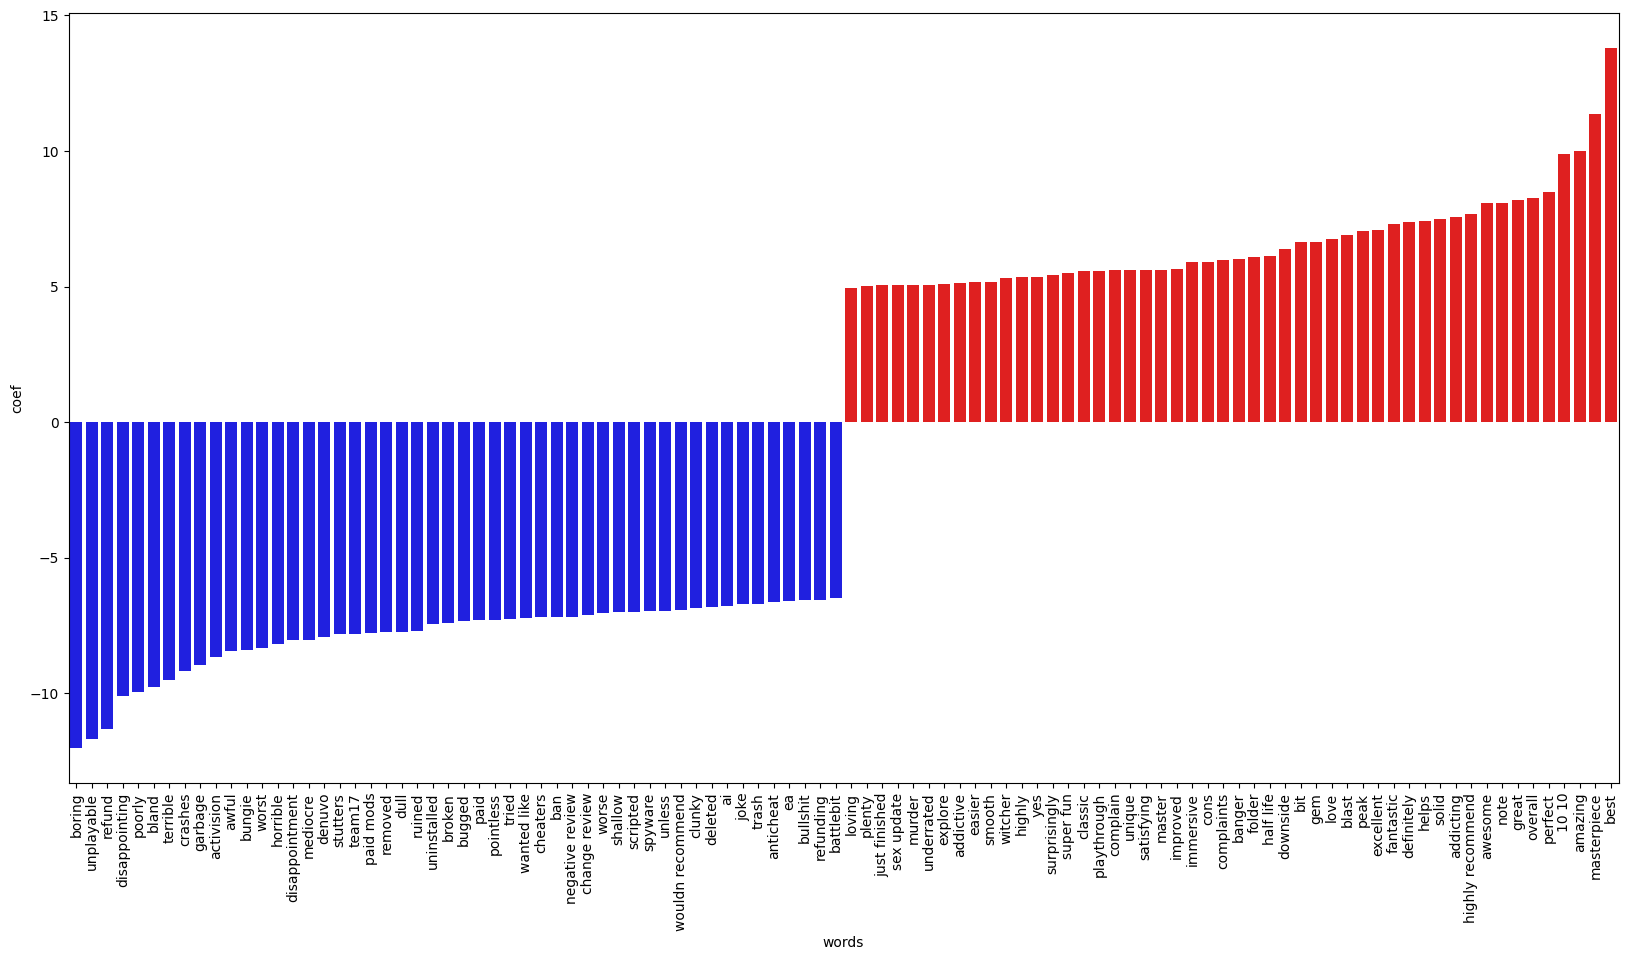

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)


sns.barplot(x=words_df['words'][:50],y=words_df['coef'][:50], color='blue')
sns.barplot(x=words_df['words'][-50:],y=words_df['coef'][-50:], color='red')
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels,rotation=90)
plt.show()

The model is going to be used to predict the outcome of a review as positive or negative. Yet there is another analysis that could be performed. We can utilize video game slang words to filter for videogame terms that could be relevant in classifiying a game as good or bad.

A list of game slang words can be found in <a href='https://en.wikipedia.org/wiki/Glossary_of_video_game_terms'>Wikipedia</a> , to find this terms the function wikipedia_slang() is used. This function is inside another function : game_slang_filter(id, n_reviews, slang:list=[], **kwargs) , this one will search for n_reviews of a game of id=id and will perform a Tfdif analysis, providing the feature_names as words, then will filter for among all this words the ones belonging to the wikipedia slang list or the slang words privided in the keyword *slang* list of the function.

Using the output of the above function, which are the slang words (game_slang) found in the reviews, we will compare them using the words_df (see in the cell above) through the function game_slang_analysis(game_slang=game_slang, words_df=words_df). This function will filter the words_df dataframe using the game_slang words and then will clasify each word as:

- very bad 
- bad 
- more or less bad
- more or less good
- good
- very good

Here i decid to calibrate the interval where each of the words belong. Only words closest to the negativest coef are considered very bad, and the same with words considered very good but with the positive coef. A lot of the words will fall into the categories of more or less bad and more or less good. These intervals can be calibrated using the interval_calibrator function.


In [12]:
def slang_statistics(id:int, n_reviews:int, model_results , slang=[]):

    #Get the reviews of a game to calculate the score
    reviews = review_builder(id_reviews_scrapper(id=id, n_rev_per_game=n_reviews))
    reviews = pd.DataFrame(reviews)
    
    #Get all the slang words of the reviews of a game
    if len(slang) != 0:
        game_slang = game_slang_filter(reviews_df=reviews,slang=slang)
    else:
        game_slang = game_slang_filter(reviews_df=reviews)

    
    
    #Model Results:
    best_model = model_results['model']
    words_df = pd.DataFrame(model_results['words'])

    #game_slang_dict: game_slang es solo un conjunto de palabras, me falta agregarles el coeficiente, asi que las filtro del words_df
    # y me quedo solo con esa parte del dataframe
    game_slang_dict = words_df[words_df['words'].isin(game_slang)].reset_index(drop=True)

    #Predigo en base a las reviews el score
    score = best_model.predict(reviews['review']).sum()/len(best_model.predict(reviews['review']))
    classification = game_slang_analysis(game_slang=game_slang, words_df=words_df)
    game_name = steam_id_name_finder(id)
    return {'score':score, 'classification':classification, 'game_slang':game_slang_dict, 'name':game_name}

In [13]:
id = 427520


In [14]:
slang_class = slang_statistics(id=id, model_results=model_results, n_reviews=500)

c:\Users\Fede\Desktop\programming\python\webscraping\notebooks\tools.py:329: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlabels,rotation=90)


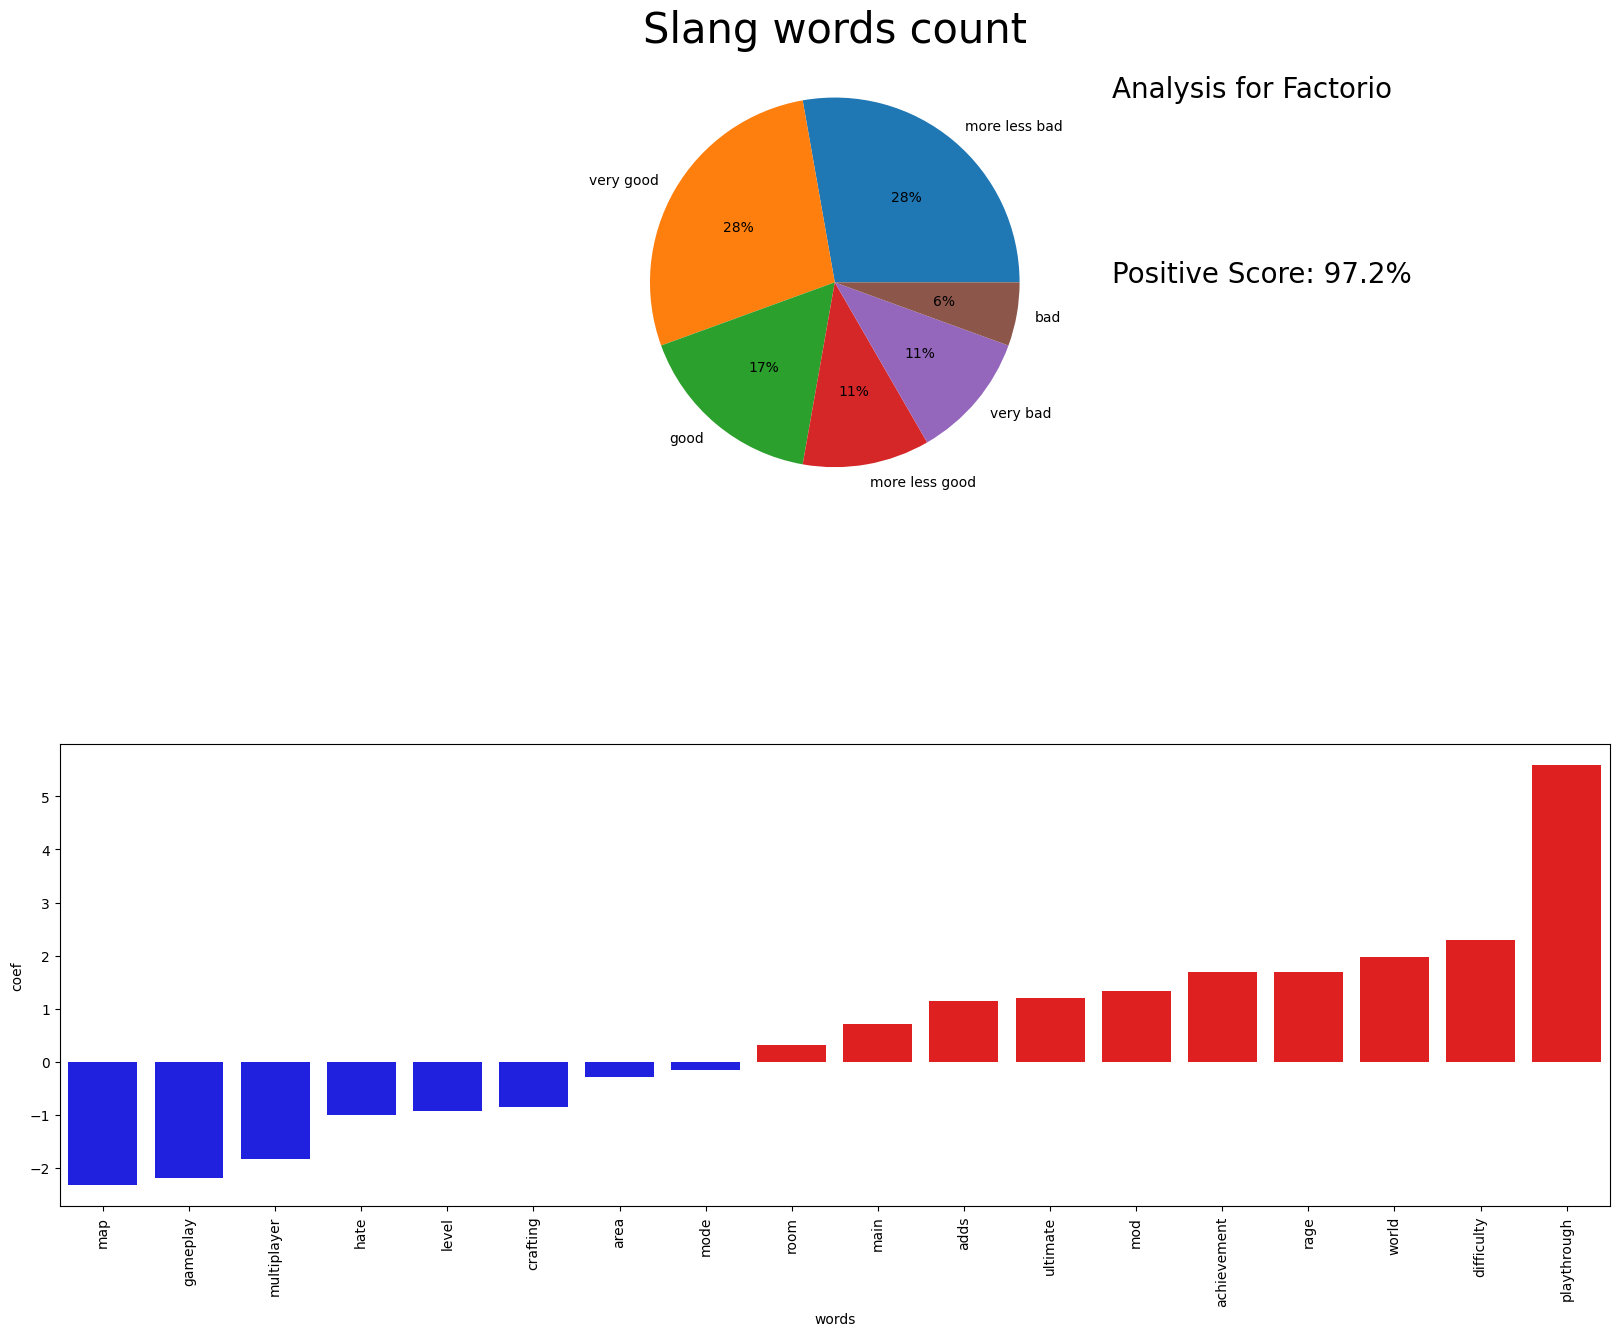

In [30]:
grpahs(slang_class=slang_class, n_words=10)

In [14]:
print(slang_class['name'],f'{slang_class['score']*100}%')

Diablo® IV 31.6%


The result is presentend in a graph with two components:

- Pie chart: Here two pieces of information are provided:
    - Positive Score: This is the outcome of the prediction of the algorithm. Remember that for a specific game, we downloaded n_reviews, and used the model trained to predict the outcome of a review as classifying a game as good or bad , this was done for n reviews, having an score of 1 for positive reviews and 0 for a negative review, to calculate the score we used the following formula:

    $$ \frac{\sum_{n} {review_n(positive)} }{\sum_{n} review_n}$$

    - Pie chart itself: Here the percentages are correspond to the coef fo the slang words present in the reviews. Remember that each coef of an slang word belongs to a category mentioned before (very bad,very good, more less good, more less bad , bad, good )

- Bar plot: Here the most relevant terms are shown in order of importance both for good and bad reviews
    

Below we have the analysis of 6 video games compared with the results provided by Steam. Because the most recent reviews are used in the analysis the prediction scores are strongly related with the recent column values of the steam reviews.

In [16]:
id_s = [1599340, 678950, 447040, 1145360, 606280, 1172470]
steam_scores = ['mostly positive','very postive','very postive','extremely positive','mostly positive', 'mostly positive']
recent_scores = ['varied', 'very postive', 'very postive', 'extremely positive', 'mostly positive', 'varied']
elements = list(zip(id_s,steam_scores))
results = {'name':[],'prediction':[],'steam_results':[]}

for e in elements:
    id = e[0]
    slang_class = slang_statistics(id=id, model_results=model_results, n_reviews=500)
    results['name'].append(slang_class['name'])
    results['prediction'].append(slang_class['score']*100 )
    results['steam_results'].append(e[1])
results['recent'] = recent_scores
pd.DataFrame(results)

,name,prediction,steam_results,recent
0,Lost Ark,28.697572,mostly positive,varied
1,DRAGON BALL FighterZ,93.947368,very postive,very postive
2,Watch_Dogs 2,73.392461,very postive,very postive
3,Hades,98.200000,extremely positive,extremely positive
4,Darksiders III,77.049180,mostly positive,mostly positive
5,Apex Legends,46.153846,mostly positive,varied


# Conclussion

- Reviews given by the comunity are very useful for determinig if a game is good or bad, but the interaction of the people with the reviews, making a review more determinant than others sometimes is related with the humor of the video game comunity. The scores and related information provided by steam for the reviews not always help to find if a reviw is good or bad regarding the appreciation of a game. An algorythim provided by sentiment analysis could help to identy the key terms that tell if a game is good or bad based both in the comunity an personal interests of a player.

- Identify game slang words in the reviews could help improve the users quest to find if a game is wether good or bad. Presented in order of relevance could help a buyer to look for personal interests regarding the enjoyement of a particular game. 